# ILS-Z639: Social Media Mining
Paper 3: Topic Modelling and Sentiment Analysis

---

## Sentiment analysis

### Importing the necessary libraries

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, model_from_json
from keras.layers import Bidirectional, Embedding, LSTM, Dense, SpatialDropout1D

### Model preparation

Preparing the training data

In [77]:
root = "stanfordSentimentTreebank/"

sentences_file = open(root + "datasetSentences.txt")
sentences = [] 
sentences_id = {}
for line in sentences_file:
	sentence = line.split("\t")[1].strip("\n")
	sentences.append(sentence)
	sentences_id[sentence] = line.split("\t")[0]
sentences_file.close()

phrase_id_file = open(root + "dictionary.txt")
phrases = {}
for line in phrase_id_file:
	line=line.split("|")
	phrases[line[0]] = line[1].strip("\n")
phrase_id_file.close()

phraseid_sentiment_file = open(root + "sentiment_labels.txt")
phrase_sentiments = {}
for line in phraseid_sentiment_file:
	line = line.split("|")
	phrase_sentiments[line[0]] = line[1].strip("\n")
phraseid_sentiment_file.close()

sentenceid_splitset_file = open(root + "datasetSplit.txt")
sentenceid_splitset = {}
for line in sentenceid_splitset_file:
	line = line.split(",")
	sentenceid_splitset[line[0]] = line[1].strip("\n")
sentenceid_splitset_file.close()

data_file = open("data.txt", "w")
data_file.write("Sentence\tScore\tLabel\n")
for sentence in sentences:
	if sentence in phrases and sentence in sentences_id:
		sentence_id = sentences_id[sentence]
		split_set = sentenceid_splitset[sentence_id]
		phrase_id = phrases[sentence]
		label = float(phrase_sentiments[phrase_id])
		label_encoding = ""
		if label >= 0 and label < 0.2:
			label_encoding = "0"
		elif label >= 0.2 and label < 0.4:
			label_encoding = "1"
		elif label >= 0.4 and label < 0.6:
			label_encoding = "2"
		elif label >= 0.6 and label < 0.8:
			label_encoding = "3"
		else:
			label_encoding = "4"
		data_file.write(sentence+"\t"+str(label)+"\t"+label_encoding+"\n")
data_file.close()

data_df = pd.read_csv('data.txt', sep='\t')

stop_words = stopwords.words('english')
data_df['Sentence'] = data_df['Sentence'].apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
data_df['Sentence'] = data_df['Sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(data_df['Sentence'].values)
X = tokenizer.texts_to_sequences(data_df['Sentence'].values)
X = pad_sequences(X, padding='post', maxlen=500)
X = np.asarray(X).astype('float32')

Y = []
for i in data_df['Label'].values:
    t = np.asarray([0., 0., 0., 0., 0.]).astype('float32')
    t[i] = 1
    Y.append(t)
Y = np.asarray(Y).astype('float32')

Defining the model

In [78]:
model = Sequential()
model.add(Embedding(50000, 500, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(500)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 500)          25000000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 500, 500)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 1000)              4004000   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 29009005 (110.66 MB)
Trainable params: 29009005 (110.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Training the model

In [79]:
#history = model.fit(X, Y, epochs=10, batch_size=250, verbose=1)

In [80]:
#model.evaluate(X, Y)

In [81]:
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("model.h5")

In [82]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

In [83]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.evaluate(X, Y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 500)          25000000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 500, 500)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 1000)              4004000   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 29009005 (110.66 MB)
Trainable params: 29009005 (110.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
353/3

[0.03289461135864258, 0.9908744692802429]

### Preparing collected data for analysis

Zara

In [84]:
df = pd.read_csv('zara.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X1 = tokenizer.texts_to_sequences(docs)
X1 = pad_sequences(X1, padding='post', maxlen=500)
X1 = np.asarray(X1).astype('float32')

616


Nike

In [85]:
df = pd.read_csv('nike.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X2 = tokenizer.texts_to_sequences(docs)
X2 = pad_sequences(X2, padding='post', maxlen=500)
X2 = np.asarray(X2).astype('float32')

959


H&M

In [86]:
df = pd.read_csv('hm.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X3 = tokenizer.texts_to_sequences(docs)
X3 = pad_sequences(X3, padding='post', maxlen=500)
X3 = np.asarray(X3).astype('float32')

480


Shein

In [87]:
df = pd.read_csv('shein.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X4 = tokenizer.texts_to_sequences(docs)
X4 = pad_sequences(X4, padding='post', maxlen=500)
X4 = np.asarray(X4).astype('float32')

656


Adidas

In [88]:
df = pd.read_csv('adidas.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X5 = tokenizer.texts_to_sequences(docs)
X5 = pad_sequences(X5, padding='post', maxlen=500)
X5 = np.asarray(X5).astype('float32')

938


Combined data

In [89]:
df = pd.read_csv('all_brands.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
X6 = tokenizer.texts_to_sequences(docs)
X6 = pad_sequences(X6, padding='post', maxlen=500)
X6 = np.asarray(X6).astype('float32')

2155


Sweat shops

In [90]:
df = pd.read_csv('sweat_shops.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
XS = tokenizer.texts_to_sequences(docs)
XS = pad_sequences(XS, padding='post', maxlen=500)
XS = np.asarray(XS).astype('float32')

1650


Fast Fashion

In [91]:
df = pd.read_csv('fast_fashion.csv')

docs = []
docs.extend(list(df['Title']))
docs.extend(list(df['Text']))
for i in list(df['Comments']):
    docs.append(i)
docs = [str(doc) for doc in set(docs) if doc]
print(len(docs))

d = pd.DataFrame({'Documents':docs})
docs = d['Documents'].apply(lambda x: str(x))

stop_words = stopwords.words('english')
docs = docs.apply(lambda x: x.lower()).apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)).str.replace('d', '').str.replace('[^ws]', '')
docs = docs.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

tokenizer = Tokenizer(num_words=50000, split=' ') 
tokenizer.fit_on_texts(docs)
XF = tokenizer.texts_to_sequences(docs)
XF = pad_sequences(XF, padding='post', maxlen=500)
XF = np.asarray(XF).astype('float32')

2155


#### Making predictions

In [92]:
Y1 = np.asarray([np.argmax(y) for y in model.predict(X1)])
Y2 = np.asarray([np.argmax(y) for y in model.predict(X2)])
Y3 = np.asarray([np.argmax(y) for y in model.predict(X3)])
Y4 = np.asarray([np.argmax(y) for y in model.predict(X4)])
Y5 = np.asarray([np.argmax(y) for y in model.predict(X5)])
Y6 = np.asarray([np.argmax(y) for y in model.predict(X6)])
YS = np.asarray([np.argmax(y) for y in model.predict(XS)])
YF = np.asarray([np.argmax(y) for y in model.predict(XF)])

68/68 [==============================] - 78s 1s/step


### Visualizations

In [93]:
count1 = dict(Counter(Y1))
count1 = {
    'Very Negative': count1[0],
    'Negative': count1[1],
    'Neutral': count1[2],
    'Positive': count1[3],
    'Very Positive': count1[4],
}
count2 = dict(Counter(Y2))
count2 = {
    'Very Negative': count2[0],
    'Negative': count2[1],
    'Neutral': count2[2],
    'Positive': count2[3],
    'Very Positive': count2[4],
}
count3 = dict(Counter(Y3))
count3 = {
    'Very Negative': count3[0],
    'Negative': count3[1],
    'Neutral': count3[2],
    'Positive': count3[3],
    'Very Positive': count3[4],
}
count4 = dict(Counter(Y4))
count4 = {
    'Very Negative': count4[0],
    'Negative': count4[1],
    'Neutral': count4[2],
    'Positive': count4[3],
    'Very Positive': count4[4],
}
count5 = dict(Counter(Y5))
count5 = {
    'Very Negative': count5[0],
    'Negative': count5[1],
    'Neutral': count5[2],
    'Positive': count5[3],
    'Very Positive': count5[4],
}
count6 = dict(Counter(Y6))
count6 = {
    'Very Negative': count6[0],
    'Negative': count6[1],
    'Neutral': count6[2],
    'Positive': count6[3],
    'Very Positive': count6[4],
}
counts = dict(Counter(YS))
counts = {
    'Very Negative': counts[0],
    'Negative': counts[1],
    'Neutral': counts[2],
    'Positive': counts[3],
    'Very Positive': counts[4],
}
countf = dict(Counter(YF))
countf = {
    'Very Negative': countf[0],
    'Negative': countf[1],
    'Neutral': countf[2],
    'Positive': countf[3],
    'Very Positive': countf[4],
}

y1 = np.array(list(count1.values()))
y2 = np.array(list(count2.values()))
y3 = np.array(list(count3.values()))
y4 = np.array(list(count4.values()))
y5 = np.array(list(count5.values()))
y6 = np.array(list(count6.values()))
ys = np.array(list(counts.values()))
yf = np.array(list(countf.values()))
x = list(count1.keys())

In [94]:
colors = sns.color_palette('viridis_r', 100)

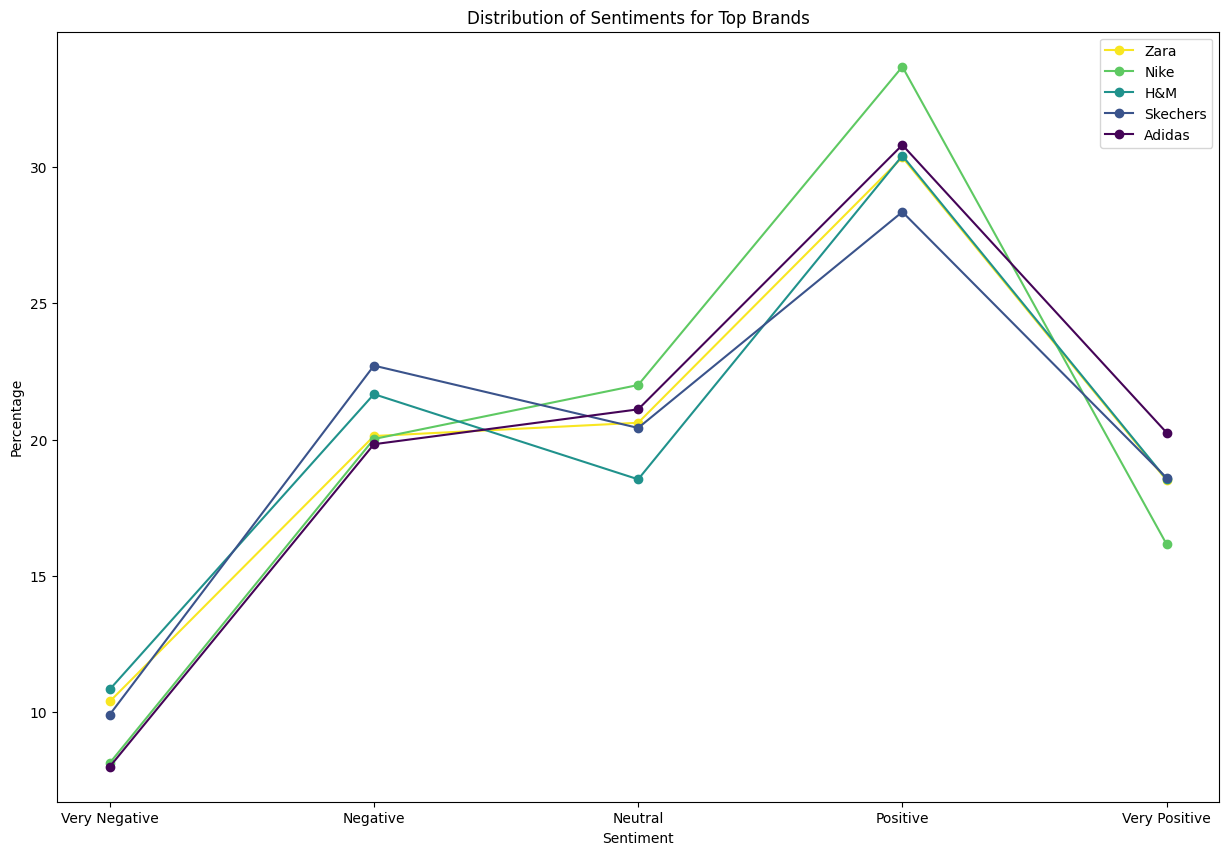

In [95]:
fig, ax = plt.subplots(figsize=(15, 10))
line1 = ax.plot(x, [(y/sum(y1))*100 for y in y1], color=colors[0], label='Zara', marker='o')
line2 = ax.plot(x, [(y/sum(y2))*100 for y in y2], color=colors[24], label='Nike', marker='o')
line3 = ax.plot(x, [(y/sum(y3))*100 for y in y3], color=colors[49], label='H&M', marker='o')
line4 = ax.plot(x, [(y/sum(y4))*100 for y in y4], color=colors[74], label='Skechers', marker='o')
line5 = ax.plot(x, [(y/sum(y5))*100 for y in y5], color=colors[99], label='Adidas', marker='o')
plt.title("Distribution of Sentiments for Top Brands")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.legend()
plt.show()

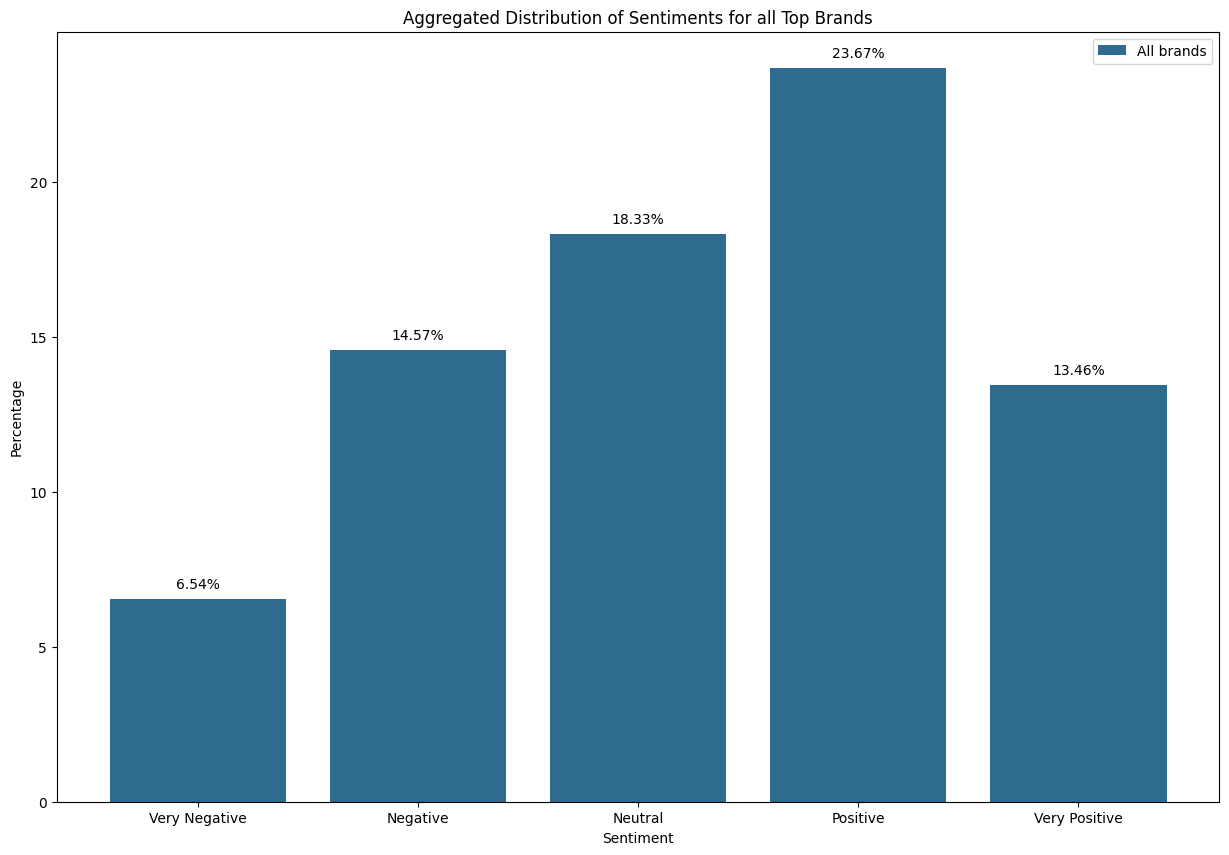

In [96]:
fig, ax = plt.subplots(figsize=(15, 10))
b = ax.bar(x, [round((y/sum(y6))*100, 2) for y in ys], color=colors[65], label='All brands')
for i, value in enumerate([round((y/sum(y6))*100, 2) for y in ys]):
    plt.text(i, value + 0.25, f"{value}%", ha='center', va='bottom')
ax.legend()
plt.title("Aggregated Distribution of Sentiments for all Top Brands")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
plt.show()

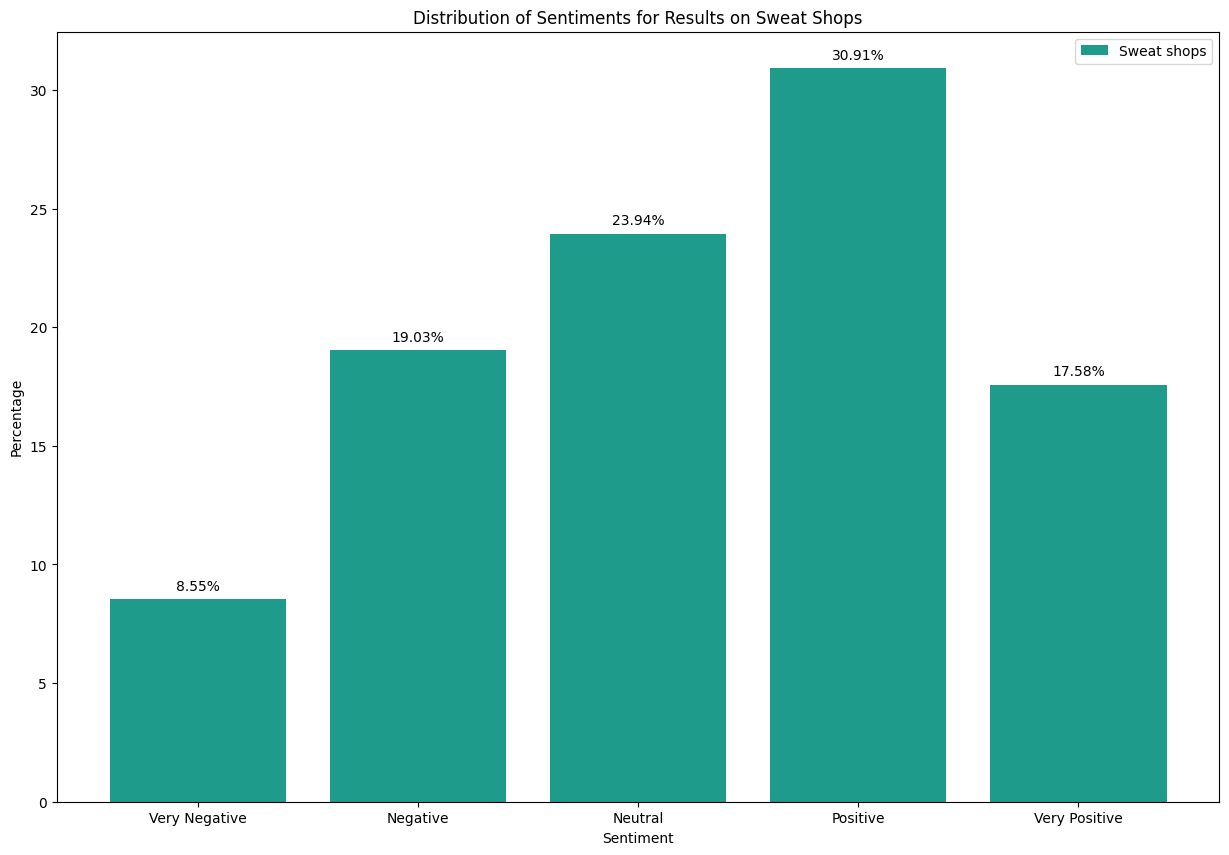

In [97]:
fig, ax = plt.subplots(figsize=(15, 10))
b = ax.bar(x, [round((y/sum(ys))*100, 2) for y in ys], color=colors[45], label='Sweat shops')
for i, value in enumerate([round((y/sum(ys))*100, 2) for y in ys]):
    plt.text(i, value + 0.25, f"{value}%", ha='center', va='bottom')
ax.legend()
plt.title("Distribution of Sentiments for Results on Sweat Shops")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
plt.show()

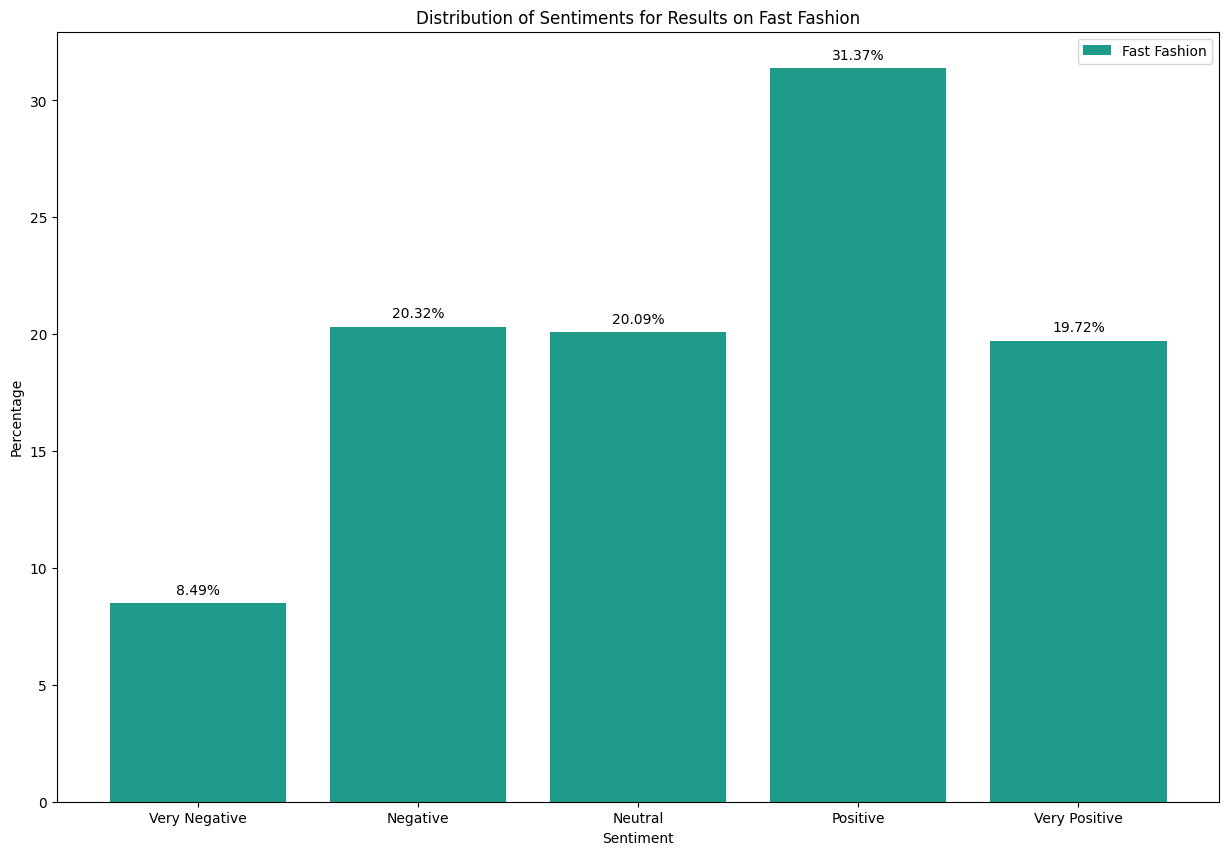

In [98]:
fig, ax = plt.subplots(figsize=(15, 10))
b = ax.bar(x, [round((y/sum(yf))*100, 2) for y in yf], color=colors[45], label='Fast Fashion')
for i, value in enumerate([round((y/sum(yf))*100, 2) for y in yf]):
    plt.text(i, value + 0.25, f"{value}%", ha='center', va='bottom')
ax.legend()
plt.title("Distribution of Sentiments for Results on Fast Fashion")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
plt.show()